1. [Load data bundle](#Load-data-bundle)

1. [Feature's Engineering](#Feature's-Engineering)
        
1. [Trading Algorithm with ML Ensemble Model](#Trading-Algorithm-with-ML-Ensemble-Model)
    1. [ML Ensemble Model Design](#ML-Ensemble-Model-Design)
    1. [Plug-in Ensemble Model implementation into Trading Bot](#Plug-in-Ensemble-Model-implementation-into-Trading-Bot)
    1. [Backtest ML Trading Strategy](#Backtest-ML-Trading-Strategy)

## Import Libraries

In [1]:
# Load IPython Magic
%load_ext watermark
%load_ext zipline

In [2]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import zipline
from yahoofinancials import YahooFinancials
import warnings


# Default working directory
# os.chdir("../data")

# Display maximum columns
pd.set_option('display.max_columns', None)

# Seaborn graphic style as default
plt.style.use('seaborn')
# Graphics default size
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 200

# Warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load data bundle
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

More details on data bundle ingesting and loading in Zipline can be found in the Jupyter Notebook <code>eda_quandl.ipynb</code>.

In [3]:
from zipline.data.data_portal import DataPortal
from zipline.data import bundles
from zipline.utils.calendars import get_calendar

import os

from zipline.utils.run_algo import load_extensions

load_extensions(
    default=True,
    extensions=[],
    strict=True,
    environ=os.environ,
)

In [4]:
bundle_data = bundles.load('quandl')

In [5]:
print(type(bundle_data))

<class 'zipline.data.bundles.core.BundleData'>


In [6]:
end_date = pd.Timestamp("2018-03-27", tz="utc")

In [7]:
bundle_data.equity_daily_bar_reader.first_trading_day

Timestamp('1990-01-02 00:00:00+0000', tz='UTC')

In [8]:
data_por = DataPortal(
    asset_finder=bundle_data.asset_finder,
    trading_calendar=get_calendar("NYSE"),
    first_trading_day=bundle_data.equity_daily_bar_reader.first_trading_day,
    equity_daily_reader=bundle_data.equity_daily_bar_reader
)

In [9]:
AAPL = data_por.asset_finder.lookup_symbol(
    'AAPL',
    as_of_date=None
)

In [10]:
df = data_por.get_history_window(
    assets=[AAPL],
    end_dt=end_date,
    bar_count=7115,
    frequency='1d',
    data_frequency='daily',
    field='open'
)

In [11]:
df.head()

,Equity(8 [AAPL])
1990-01-02 00:00:00+00:00,35.25
1990-01-03 00:00:00+00:00,38.00
1990-01-04 00:00:00+00:00,38.25
1990-01-05 00:00:00+00:00,37.75
1990-01-08 00:00:00+00:00,37.50


In [12]:
df.index = pd.DatetimeIndex(df.index)

In [13]:
df['close'] = df[list(df.columns)[0]]

In [14]:
df = df.drop(columns=[list(df.columns)[0]])
df.head()

,close
1990-01-02 00:00:00+00:00,35.25
1990-01-03 00:00:00+00:00,38.00
1990-01-04 00:00:00+00:00,38.25
1990-01-05 00:00:00+00:00,37.75
1990-01-08 00:00:00+00:00,37.50


# Feature's Engineering
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

Algorithmic trading strategies are driven by signals that trigger buy and sell asset orders aiming at generating superior returns relative to a benchmark (such as an index). The part of an asset's return that is not explained by exposure to this benchmark is called alpha, and hence the signals producing such uncorrelated returns are also called <b>alpha factors</b>. <br>

More concretely, alpha factors are transformations of raw market, fundamental or alternative data, that aim to predict asset price movements. They are designed to capture risks that drive asset returns. Every time the trading strategy evaluates the factor, it obtains a signal.<br>

In theory, risk factors should be independent of each other, but more often than not, they appear to be correlated. For this reason, it is adviced to consider one or more factors in trading. The most common ones in trading are momentum and sentiment factors and fundamental (or value) factors.

Zipline provides many built-in factors from a broad range of data sources, that can be combined with other Python libraries (Numpy, Pandas, Ta-lib) to derive more complex factors. However, for this particular project, we shall be concerned with <b>technical analysis</b> and disregard other factors explaining asset returns.<br>

We shall devise an intuitive and simple strategy: with 40 forward simple returns' newly-created variables, and for each point in time, we shall train 32 values and predict the remaining 8 ones. This converts our problem into a <i>multi-target regression</i>, which we shall address conveniently in further steps.

## Factor's preprocessing

In [15]:
df['1d'] = df.shift(-1)

In [16]:
for d in range(2, 41):
    col = '%dd'% d
    df[col] = df['close'].shift(-1 * d)

In [17]:
df = df.dropna()

In [18]:
df.tail()

,close,1d,2d,3d,4d,5d,6d,7d,8d,9d,10d,11d,12d,13d,14d,15d,16d,17d,18d,19d,20d,21d,22d,23d,24d,25d,26d,27d,28d,29d,30d,31d,32d,33d,34d,35d,36d,37d,38d,39d,40d
2018-01-23 00:00:00+00:00,177.300,177.250,174.505,172.000,170.160,165.525,166.870,167.165,166.000,159.100,154.830,163.085,160.290,157.070,158.500,161.950,163.045,169.79,172.36,172.05,172.83,171.80,173.67,176.35,179.10,179.26,178.54,172.80,175.21,177.91,174.94,175.48,177.96,180.29,182.59,180.32,178.50,178.65,177.32,175.24,175.04
2018-01-24 00:00:00+00:00,177.250,174.505,172.000,170.160,165.525,166.870,167.165,166.000,159.100,154.830,163.085,160.290,157.070,158.500,161.950,163.045,169.790,172.36,172.05,172.83,171.80,173.67,176.35,179.10,179.26,178.54,172.80,175.21,177.91,174.94,175.48,177.96,180.29,182.59,180.32,178.50,178.65,177.32,175.24,175.04,170.00
2018-01-25 00:00:00+00:00,174.505,172.000,170.160,165.525,166.870,167.165,166.000,159.100,154.830,163.085,160.290,157.070,158.500,161.950,163.045,169.790,172.360,172.05,172.83,171.80,173.67,176.35,179.10,179.26,178.54,172.80,175.21,177.91,174.94,175.48,177.96,180.29,182.59,180.32,178.50,178.65,177.32,175.24,175.04,170.00,168.39
2018-01-26 00:00:00+00:00,172.000,170.160,165.525,166.870,167.165,166.000,159.100,154.830,163.085,160.290,157.070,158.500,161.950,163.045,169.790,172.360,172.050,172.83,171.80,173.67,176.35,179.10,179.26,178.54,172.80,175.21,177.91,174.94,175.48,177.96,180.29,182.59,180.32,178.50,178.65,177.32,175.24,175.04,170.00,168.39,168.07
2018-01-29 00:00:00+00:00,170.160,165.525,166.870,167.165,166.000,159.100,154.830,163.085,160.290,157.070,158.500,161.950,163.045,169.790,172.360,172.050,172.830,171.80,173.67,176.35,179.10,179.26,178.54,172.80,175.21,177.91,174.94,175.48,177.96,180.29,182.59,180.32,178.50,178.65,177.32,175.24,175.04,170.00,168.39,168.07,173.68


In [19]:
for i in reversed(range(2, 41)):
    col = '%dd' % i
    prev = '%dd' % (i - 1)
    df[col] = (df[col] - df[prev]) / df[prev]

In [20]:
df['1d'] = (df['1d'] - df['close']) / df['close']

In [21]:
df = df.drop(columns=['close'])

In [22]:
df.tail()

,1d,2d,3d,4d,5d,6d,7d,8d,9d,10d,11d,12d,13d,14d,15d,16d,17d,18d,19d,20d,21d,22d,23d,24d,25d,26d,27d,28d,29d,30d,31d,32d,33d,34d,35d,36d,37d,38d,39d,40d
2018-01-23 00:00:00+00:00,-0.000282,-0.015487,-0.014355,-0.010698,-0.027239,0.008126,0.001768,-0.006969,-0.041566,-0.026838,0.053317,-0.017138,-0.020089,0.009104,0.021767,0.006761,0.041369,0.015136,-0.001799,0.004534,-0.005960,0.010885,0.015432,0.015594,0.000893,-0.004017,-0.032150,0.013947,0.015410,-0.016694,0.003087,0.014133,0.013093,0.012757,-0.012432,-0.010093,0.000840,-0.007445,-0.011730,-0.001141
2018-01-24 00:00:00+00:00,-0.015487,-0.014355,-0.010698,-0.027239,0.008126,0.001768,-0.006969,-0.041566,-0.026838,0.053317,-0.017138,-0.020089,0.009104,0.021767,0.006761,0.041369,0.015136,-0.001799,0.004534,-0.005960,0.010885,0.015432,0.015594,0.000893,-0.004017,-0.032150,0.013947,0.015410,-0.016694,0.003087,0.014133,0.013093,0.012757,-0.012432,-0.010093,0.000840,-0.007445,-0.011730,-0.001141,-0.028793
2018-01-25 00:00:00+00:00,-0.014355,-0.010698,-0.027239,0.008126,0.001768,-0.006969,-0.041566,-0.026838,0.053317,-0.017138,-0.020089,0.009104,0.021767,0.006761,0.041369,0.015136,-0.001799,0.004534,-0.005960,0.010885,0.015432,0.015594,0.000893,-0.004017,-0.032150,0.013947,0.015410,-0.016694,0.003087,0.014133,0.013093,0.012757,-0.012432,-0.010093,0.000840,-0.007445,-0.011730,-0.001141,-0.028793,-0.009471
2018-01-26 00:00:00+00:00,-0.010698,-0.027239,0.008126,0.001768,-0.006969,-0.041566,-0.026838,0.053317,-0.017138,-0.020089,0.009104,0.021767,0.006761,0.041369,0.015136,-0.001799,0.004534,-0.005960,0.010885,0.015432,0.015594,0.000893,-0.004017,-0.032150,0.013947,0.015410,-0.016694,0.003087,0.014133,0.013093,0.012757,-0.012432,-0.010093,0.000840,-0.007445,-0.011730,-0.001141,-0.028793,-0.009471,-0.001900
2018-01-29 00:00:00+00:00,-0.027239,0.008126,0.001768,-0.006969,-0.041566,-0.026838,0.053317,-0.017138,-0.020089,0.009104,0.021767,0.006761,0.041369,0.015136,-0.001799,0.004534,-0.005960,0.010885,0.015432,0.015594,0.000893,-0.004017,-0.032150,0.013947,0.015410,-0.016694,0.003087,0.014133,0.013093,0.012757,-0.012432,-0.010093,0.000840,-0.007445,-0.011730,-0.001141,-0.028793,-0.009471,-0.001900,0.033379


Let's now split the series between features and targets.

In [23]:
# Create features (X) and targets (y)
X = df.iloc[:,:32]
y = df.iloc[:,32:]


In [24]:
X.shape

(6993, 32)

# Trading Algorithm with ML Ensemble Model
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

<b>Ensemble Model</b><br>
Ensembling is a method for combining base models and is based on the hypothesis that a much more powerful model can be produced by combining multiple models together. There are different types of ensemble modelling:<br>
<ul>
    <li><b>Bagging</b>: short for bootstrap aggregation, uses bootstrap sampling to obtain data subsets for training 'base learners' and reduces variance. The most common algorithm is Random Forest, the process of generation is parallel and the base learner output in regression is averaging,</li>
    <li><b>Boosting</b>: converts 'weak learners' to strong learners and reduces bias. The most common algorithm is AdaBoost, the process of generation is sequential and the base learner output in regression is weighted sum,</li>
    <li><b>Stacking</b>: combines multiple models via a meta-model and improves predictions</li>
</ul>
In this section, we will tackle all three methods.<br>
Libraries used here are mainly <code>scikit-learn</code> and, to a lesser extent, <code>scipy</code>.

<b>Neural Networks and Zipline</b><br>
<code>Keras</code> and <code>Tensorflow</code> are not supported in local Zipline research environment. Though having installed both, a message error is displayed when importing them. It appears that, to date, no satisfactory and technically feasible solutions have been found to port the DL algorithm into the Zipline local platform. For that reason, and regrettably enough, deep learning models cannot be performed in this project but will be explored in the future.<br>

Particularly, Long-Short Term Memory (LSTM) and Echo State Networks (ESN) models, falling under the family of  Recurrent Neural Networks, seem to work fine with financial time series, since they are able to capture non-linear relationships among variables and correct for vanishing gradient descents.

<b>Step-by-step approach</b><br>
In this section, we shall:
<ol>
    <li>build a baseline model</li>
    <li>assess the performance of other models</li>
    <li>create custom functions for stacking ensemble models:</li>
    <ol>
        <li><code>get_stacking()</code>: this function will create the layers of our <code>StackingRegressor()</code></li>
        <li><code>get_model()</code>: this function will create a dictionary of models to be evaluated</li>
        <li><code>evaluate_model()</code>: this function will evaluate each of the models</li>
        <li><code>best_model()</code>: this function will return the best model after creating a model pipeline and performing hyperparameter tuning</li>
    </ol> 
    <li>export best model's results in a joblib format</li>
</ol>

This section's approach has been inspired from the Data Camp Live Training: Applied Machine Learning - Ensembling Modelling, by Lisa Stuart. 

### Import Libraries

In [69]:
# Sklearn model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

# Regressors
import sklearn.linear_model as LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor
from sklearn.neighbors import KNeighborsRegressor

# Data Scaling (for KNN-neighbours)
from sklearn.preprocessing import scale

# Hyperparameter tuning
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV

# Cross-validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict

# Metrics
from sklearn.metrics import r2_score

### Train, Test, Split

Considering that financial times series are not independently and identically distibuted, on grounds of serial autocorrelation and time-varying standard deviation, we shall use TimeSeriesSplit object from sklearn to allow for incremental cross validation.

In [33]:
tscv = TimeSeriesSplit(n_splits=10)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    print(X_train.shape, y_train.shape)
    print(X_test.shape, y_test.shape)

(643, 32) (643, 8)
(635, 32) (635, 8)
(1278, 32) (1278, 8)
(635, 32) (635, 8)
(1913, 32) (1913, 8)
(635, 32) (635, 8)
(2548, 32) (2548, 8)
(635, 32) (635, 8)
(3183, 32) (3183, 8)
(635, 32) (635, 8)
(3818, 32) (3818, 8)
(635, 32) (635, 8)
(4453, 32) (4453, 8)
(635, 32) (635, 8)
(5088, 32) (5088, 8)
(635, 32) (635, 8)
(5723, 32) (5723, 8)
(635, 32) (635, 8)
(6358, 32) (6358, 8)
(635, 32) (635, 8)


## ML Ensemble Model Design
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

### 1. Baseline Model

We shall use the scoring metric MAE, mean absolute value, negated so as to uniform sklearn handling <br>
 
 <blocquote>MAE = $\frac{1}{n}\sum_{t=1}^{n}|e_t|$</blocquote> <br>
 
 the closer to zero values, the better

#### Dummy Regressor

In [54]:
# Evaluate naive

# Instantiate a DummyRegressor with 'median' strategy
naive = DummyRegressor(strategy='mean')

# Calculate accuracy using `cross_val_score()` with model instantiated, data to fit, target variable, 'neg_mean_absolute_error' scoring, cross validator, n_jobs=-1, and error_score set to 'raise'
n_scores = cross_val_score(naive, X, y, scoring='neg_mean_absolute_error', cv=tscv, n_jobs=-1, error_score='raise')

# Print mean and standard deviation of n_scores:
print('Baseline: mean (%.3f), std (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Baseline: mean (-0.020), std (0.006)


We shall have this dummy regressor as baseline, and we will try to improve from here.

### 2. Other ML Models

#### Support Vector Machine

In [55]:
# Evaluate baseline model

# Instantiate a Support Vector Regressor with 'rbf' kernel, gamma set to 'scale', and regularization parameter set to 10
svr = SVR(kernel='rbf',gamma='scale',C=10)

# Pass a MultiOutputRegressor to model
wrapper = MultiOutputRegressor(svr)

# Calculate accuracy using `cross_val_score()` with model instantiated, data to fit, target variable, 'neg_mean_absolute_error' scoring, cross validator 'cv', n_jobs=-1, and error_score set to 'raise'
m_scores = cross_val_score(wrapper, X, y, scoring='neg_mean_absolute_error', cv=tscv, n_jobs=-1, error_score='raise')

# Print mean and standard deviation of m_scores: 
print('Good: %.3f (%.3f)' % (np.mean(m_scores), np.std(m_scores)))

Good: -0.028 (0.009)


#### Decision Trees

In [81]:
# First, create an Instance
dt = DecisionTreeRegressor(max_depth=10)

# Second, create a dictionnary of hyperparameters to search
dt_scores = cross_val_score(dt, X, y, scoring='neg_mean_absolute_error', cv=tscv, n_jobs=-1, error_score='raise')
    
# Print mean and standard deviation of m_scores: 
print('Good: %.3f (%.3f)' % (np.mean(dt_scores), np.std(dt_scores)))

Good: -0.021 (0.007)



#### Random Forest

In [56]:
# First, create an Instance
rfr = RandomForestRegressor(n_estimators=200, max_depth=3, max_features=8)

# Second, create a dictionnary of hyperparameters to search
m_scores = cross_val_score(rfr, X, y, scoring='neg_mean_absolute_error', cv=tscv, n_jobs=-1, error_score='raise')
    
# Print mean and standard deviation of m_scores: 
print('Good: %.3f (%.3f)' % (np.mean(m_scores), np.std(m_scores)))
    

Good: -0.020 (0.006)


In [57]:
# Fit the model
rfr.fit(X_train, y_train)

# Make predictions
train_pred_rfr = rfr.predict(X_train)
test_pred_rfr = rfr.predict(X_test)

In [62]:
print(rfr.score(X_train,y_train))
print(rfr.score(X_test,y_test))

0.017038834730270274
-0.0004532026411183098


#### Gradient Boosting Trees

In [63]:
# Create GB model -- hyperparameters (to be tuned!!)
gbr = GradientBoostingRegressor(max_features=4,
                                learning_rate=0.01,
                                n_estimators=200,
                                subsample=0.6,
                                random_state=42)

# For multiple target predictions, we shall use MultiOutputRegressor
gbr = MultiOutputRegressor(gbr)

In [64]:
cross_validate(gbr, X, y=y, cv=tscv, scoring='neg_mean_squared_error')

{'fit_time': array([0.52585816, 0.73023129, 1.01138783, 1.32176328, 1.65325546,
        1.73881555, 1.98792124, 2.23792577, 2.48536158, 2.74260569]),
 'score_time': array([0.00929427, 0.01010704, 0.01220846, 0.01109362, 0.00886464,
        0.00843167, 0.00871682, 0.00762463, 0.0073843 , 0.00714231]),
 'test_score': array([-0.00093989, -0.00116107, -0.00148825, -0.0022743 , -0.00100386,
        -0.00058777, -0.00095038, -0.00033781, -0.00146699, -0.00030813]),
 'train_score': array([-0.00066468, -0.0007575 , -0.00085825, -0.00100481, -0.00120102,
        -0.00114661, -0.00106929, -0.0010576 , -0.00097912, -0.00101937])}

In [65]:
cross_val_score(gbr, X, y=y, cv=tscv, scoring='neg_mean_squared_error')

array([-0.00093989, -0.00116107, -0.00148825, -0.0022743 , -0.00100386,
       -0.00058777, -0.00095038, -0.00033781, -0.00146699, -0.00030813])

In [146]:
gbr.fit(X_train, y_train)
train_pred_gbr = gbr.predict(X_train)
test_pred_gbr = gbr.predict(X_test)
print(gbr.score(X_train, y_train))
print(gbr.score(X_test, y_test))

0.07563548925157097
-0.007474131207838436


#### K-Neighbors

Some models, like K-nearest neighbors (KNN), work better with scaled data -- so we'll standardize our data. KNN uses distances to find similar points for predictions, so big features outweigh small ones. Scaling data fixes that.<br>
Sklearn's <code>scale()</code> will standardize data, which sets the mean to 0 and standard deviation to 1.

In [74]:
# Standardize features
scaled_X = scale(X)
# scaled_y = scale(y)

In [80]:
# Create and fit the KNN model
knn = KNeighborsRegressor(n_neighbors=5)
 
# Second, create a dictionnary of hyperparameters to search
knn_scores = cross_val_score(rfr, scaled_X, y, scoring='neg_mean_absolute_error', cv=tscv, n_jobs=-1, error_score='raise')
    
# Print mean and standard deviation of m_scores: 
print('Good: %.3f (%.3f)' % (np.mean(knn_scores), np.std(knn_scores)))


Good: -0.020 (0.006)


In [77]:
# Standardize the train and test features
scaled_X_train = scale(X_train)
scaled_X_test = scale(X_test)

In [78]:
# Fit the model to the training data
knn.fit(scaled_X_train, y_train)
    
# Print the score
print(knn.score(scaled_X_train, y_train))
print(knn.score(scaled_X_test, y_test))

0.196877733594022
-0.6891917966096704


-3.051755878782225
-1.4617462672012067


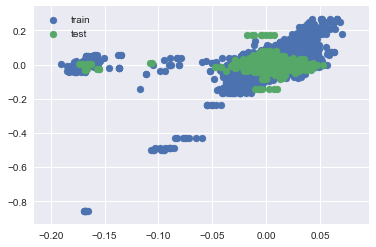

In [79]:
# Evaluate the model
train_pred_knn = knn.predict(scaled_X_train)
test_pred_knn = knn.predict(scaled_X_test)

# Plot the actual vs predicted values
plt.scatter(train_pred_knn, y_train, label='train')
plt.scatter(test_pred_knn, y_test, label='test')
plt.legend()

print(r2_score(train_pred_knn, y_train))
print(r2_score(test_pred_knn, y_test))


### Ensemble Model

### 4. Export best model in a joblib format

In [29]:
# Export trained models and save it for future predictions
from joblib import dump
dump(best_regressor, '../strategies/models/best_regressor.joblib')

['../strategies/models/rfr_regressor.joblib']

## Plug-in Ensemble Model implementation into Trading Bot
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

We modify the <code>buy_and_hold.py</code> Python script (strategies folder) to account for, ceteris paribus:
<ul>
    <li>lagged and forecast values</li>
    <li>under the <code>initialize </code>function, load our RF regressor joblib </li>
    <li>under the <code>handle_data</code> function:<br>
        <ol>
        <li>create one array with lagged 32 values for each point in time and  one array with 8 forecast values, and</li>
        <li>code the strategy: if the max predictive value is above the mean of historical/past values, then we place a buy order and viceversa</li>
        </ol>
    

The portfolio value has reached a value of round 228 million EUR, whereas the classic strategy BuyAndHold recorded a value of round 561.100 EUR.

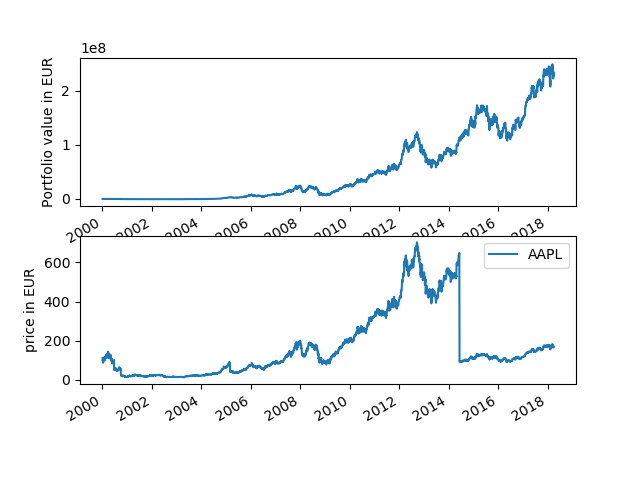

## Backtest ML Trading Strategy
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

In [35]:
df = pd.read_csv('../reports/buy_and_hold.csv')

In [36]:
df = df.rename(columns={'Unnamed: 0':'date'}).set_index('date')

<Figure size 1296x576 with 0 Axes>

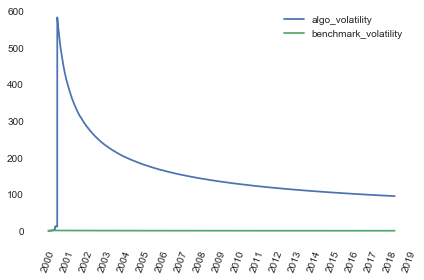

In [48]:
from matplotlib import pyplot as plt
from matplotlib.dates import YearLocator, date2num, DateFormatter

plt.figure(figsize = (18, 8))

df.index = pd.DatetimeIndex(df.index)

fig, ax = plt.subplots()

fig.subplots_adjust(bottom=0.3)

# Create a plot
ax.plot(df.index, df.algo_volatility)
ax.plot(df.index, df.benchmark_volatility)

lctr = YearLocator()
frmt = DateFormatter('%Y')

# Final formatting
ax.xaxis.set_major_locator(lctr)
ax.xaxis.set_major_formatter(frmt)

plt.xticks(rotation=70)
plt.tight_layout()

plt.legend()
plt.show()

<Figure size 1296x576 with 0 Axes>

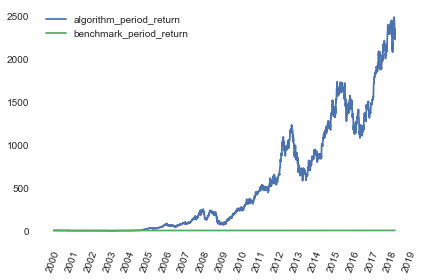

In [49]:
from matplotlib import pyplot as plt
from matplotlib.dates import YearLocator, date2num, DateFormatter

plt.figure(figsize = (18, 8))

df.index = pd.DatetimeIndex(df.index)

fig, ax = plt.subplots()

fig.subplots_adjust(bottom=0.3)

# Create a plot
ax.plot(df.index, df.algorithm_period_return)
ax.plot(df.index, df.benchmark_period_return)

lctr = YearLocator()
frmt = DateFormatter('%Y')

# Final formatting
ax.xaxis.set_major_locator(lctr)
ax.xaxis.set_major_formatter(frmt)

plt.xticks(rotation=70)
plt.tight_layout()

plt.legend()
plt.show()

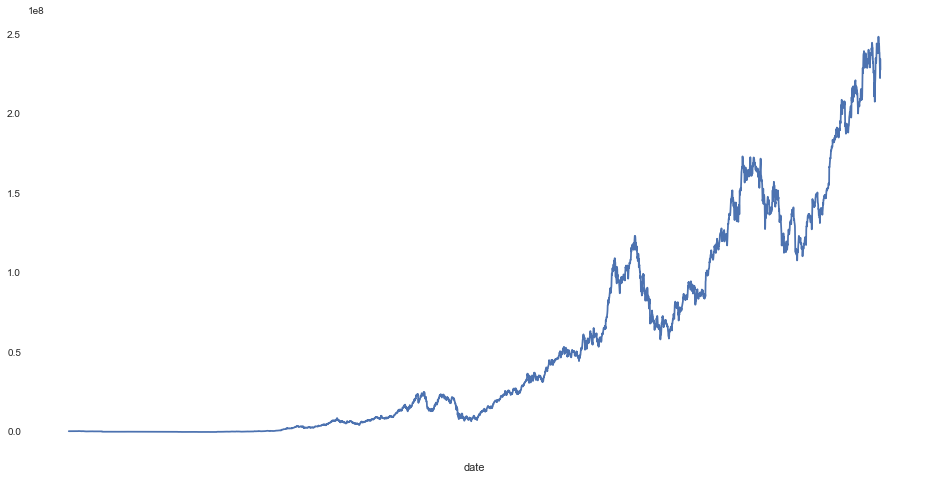

In [37]:
df.portfolio_value.plot(figsize=(16,8))

In [38]:
'${:.2f}'.format(df.capital_used.sum())

'$-33730147.25'

In [39]:
'${:.2f}'.format(df.portfolio_value[-1])

'$227667200.75'

In [40]:
'${:.2f}'.format(df.capital_used.sum() + df.portfolio_value[-1])

'$193937053.51'

## Gradient Boosting Models
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

### Gradient Boosting Model

In [42]:
# Create GB model -- hyperparameters (to be tuned!!)
gbr = GradientBoostingRegressor(max_features=4,
                                learning_rate=0.01,
                                n_estimators=200,
                                subsample=0.6,
                                random_state=42)
gbr.fit(X_train, y_train)

print(gbr.score(X_train, y_train))
print(gbr.score(X_test, y_test))

ValueError: bad input shape (5846, 8)